# ***ATTENTION IS ALL YOU NEED - Paper Explanation ***


1.   Framework : PyTorch
2.   Dataset   : Multi30K






> Special thanks to Rishaab, Bentretvet, Jay Alammar, Aladdin Pearson



>Dont hesitate to get help from : 
https://github.com/rishabkr/Attention-Is-All-You-Need-Explained-PyTorch/blob/main/Attention-is-All-You-Need%20Paper%20Implementation(PyTorch)%20.ipynb 










In [1]:
import torch
print(torch.__version__) 

1.9.0+cu102


Import the dependencies

In [2]:
#To define the model:
import torch
import torch.nn as nn
import torch.optim as optim
#to load,iterate and process the dataset
import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.data.metrics import bleu_score
from torchtext.legacy.data import Field, BucketIterator
#to visualize loss plots on localhost while training
from torch.utils.tensorboard import SummaryWriter
#miscallaneous imports
import math
import spacy 
import random
import numpy as np
from time import time
from tqdm.notebook import tqdm #Instantly make your loops show a smart progress meter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker #classes for configuring tick locating and formatting.

In [3]:
# get GPU details if available

def get_gpu_details():
    t = torch.cuda.get_device_properties(0).total_memory
    c = torch.cuda.memory_cached(0)
    a = torch.cuda.memory_allocated(0)
    print(torch.cuda.get_device_name())
    print(f'Total GPU Memory {t} B , Cached GPU Memory {c} B, Allocated GPU Memory {a} B')

if torch.cuda.is_available():
    device='cuda:0'
else:
    device='cpu'
print(f'Current Device: {device}')
if device=='cuda:0':
    torch.cuda.empty_cache()
    get_gpu_details()

Current Device: cpu


In [4]:
#Assign Seed and batch_size for deterministic results
batch_size = 128
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
!python -m spacy download de_core_news_sm

     |████████████████████████████████| 14.9MB 5.3MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907055 sha256=a6448986d75715775dad8def6cface6e95be51d91ccd1a609e0f36b0e13d2de7
  Stored in directory: /tmp/pip-ephem-wheel-cache-sy0yq_sl/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [5]:
#Download spacy moddules for English and Germany langugaes:
spacy_german = spacy.load('de_core_news_sm')    
spacy_english = spacy.load('en_core_web_sm')
#*If german model doesnot get loaded even after previous installation pls restart the runtime and try

In [6]:
#Define the tokenizer for both models
def tokenize_english(eng_text):
    return [token.text for token in spacy_english.tokenizer(eng_text)]

def tokenize_german(german_text):
    return [token.text for token in spacy_german.tokenizer(german_text)]
    
print(tokenize_english('I love you Divine Mother!'),tokenize_german('Lassen Sie uns ein Spiel spielen'))

['I', 'love', 'you', 'Divine', 'Mother', '!'] ['Lassen', 'Sie', 'uns', 'ein', 'Spiel', 'spielen']


In [7]:
#Create text processing pipelines:

source_process_pipeline = Field(tokenize = tokenize_german,
                       init_token = '<sos>',
                       eos_token = '<eos>',
                       lower = True,
                       batch_first = True)

target_process_pipeline = Field(tokenize = tokenize_english,
                       init_token = '<sos>',
                       eos_token = '<eos>',
                       lower = True,
                       batch_first = True)
#Each sequence should starts with <sos> and end with <eos> 
#Each sequence must be lowercase 
#first channel of the input to the model will be batch, so set batch_first = True

In [8]:
# Data Split:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (source_process_pipeline,target_process_pipeline))
#Data is basically arranged ro support seq2seq models
#Two modules are there which are .de and .en for german and english respectively
#Here we field out those modules and split those into three data set

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 1.19MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 233kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 216kB/s]


In [9]:
len(train_data),len(valid_data),len(test_data)

(29000, 1014, 1000)

In [10]:
#Building Vocabulary:(From train_data)
source_process_pipeline.build_vocab(train_data,min_freq=2)
target_process_pipeline.build_vocab(train_data,min_freq=2)
#Condition for unique is 2
len(source_process_pipeline.vocab),len(target_process_pipeline.vocab)

(7855, 5893)

In [11]:
list(source_process_pipeline.vocab.stoi.items())[:50],list(target_process_pipeline.vocab.stoi.items())[:50]

([('<unk>', 0),
  ('<pad>', 1),
  ('<sos>', 2),
  ('<eos>', 3),
  ('.', 4),
  ('ein', 5),
  ('einem', 6),
  ('in', 7),
  ('eine', 8),
  (',', 9),
  ('und', 10),
  ('mit', 11),
  ('auf', 12),
  ('mann', 13),
  ('einer', 14),
  ('der', 15),
  ('frau', 16),
  ('die', 17),
  ('zwei', 18),
  ('einen', 19),
  ('im', 20),
  ('an', 21),
  ('von', 22),
  ('sich', 23),
  ('dem', 24),
  ('mädchen', 25),
  ('junge', 26),
  ('vor', 27),
  ('zu', 28),
  ('steht', 29),
  ('männer', 30),
  ('sitzt', 31),
  ('hund', 32),
  ('den', 33),
  ('straße', 34),
  ('während', 35),
  ('gruppe', 36),
  ('hält', 37),
  ('spielt', 38),
  ('das', 39),
  ('hemd', 40),
  ('personen', 41),
  ('über', 42),
  ('drei', 43),
  ('eines', 44),
  ('frauen', 45),
  ('blauen', 46),
  ('neben', 47),
  ('ist', 48),
  ('kind', 49)],
 [('<unk>', 0),
  ('<pad>', 1),
  ('<sos>', 2),
  ('<eos>', 3),
  ('a', 4),
  ('.', 5),
  ('in', 6),
  ('the', 7),
  ('on', 8),
  ('man', 9),
  ('is', 10),
  ('and', 11),
  ('of', 12),
  ('with', 13),


In [12]:
#Iterator Settings:
train_iterator, validation_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = batch_size,
     device = device)
print(next(iter(train_iterator)))
#Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch. See pool for the bucketing procedure used.


[torchtext.legacy.data.batch.Batch of size 128 from MULTI30K]
	[.src]:[torch.LongTensor of size 128x23]
	[.trg]:[torch.LongTensor of size 128x21]


In [13]:
len(train_iterator),len(validation_iterator),len(test_iterator)

(227, 8, 8)

# **BUILDING TRANSFORMER MODEL**

In [14]:
                                                                                             #Encoder part 1>>>>>>>>
#input_dimension = source_process_pipeline.vocab
#hidden_dimension = 256 (Assume)   i.e linguistic feature or embedding dim
#number_encode_layers = 3 (Assume)
#num_attention_heads = 8(Assume)
#pointwise_ff_dim = 512(Assume) 
#dropout = 0.1 (Assume)
#max_length = maximum sentence length = 100 (Assume) #includes pad
class Encoder(nn.Module):
    def __init__(self,input_dimension,hidden_dimension,
                 number_encoder_layers,num_attention_heads,pointwise_ff_dim,
                 dropout,device,max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.token_embeddings = nn.Embedding(input_dimension,hidden_dimension) 
        self.positional_embeddings = nn.Embedding(max_length,hidden_dimension)
#token_embeddings and positional_embeddings are summed together and becomes product of embedding
#Before they get to sum,multiply token embeddings with scalar value governed from hidden_dimension        
        
        self.encoder_blocks = nn.ModuleList([EncoderBlock(hidden_dimension,num_attention_heads,
                                                  pointwise_ff_dim,dropout,device)
                                     for _ in range(number_encoder_layers)])
#Encoder block of each layer inheritance        
        self.dropout = nn.Dropout(dropout)
#Drop out layer added        
        # sqrt(d_model)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dimension])).to(device)
#Use this scale value to multiply token embeddings       
        
    def forward(self,source,source_mask):
        
        #src = (batchsize,source length)
        #src_mask = (batch size,1,1,source length)
        
        batch_size = source.shape[0]
        source_length = source.shape[1]
          
        positions = torch.arange(0,source_length).unsqueeze(0)
#positions = (source_length,1)
# a range of (0 to sentence length of each and source sentence)
        
        positions = positions.repeat(batch_size,1).to(self.device)
#positions = (batch_size,source_length)
#Integrate the previous to batch size of 128
        
#add the token_embeddings to positional_encodings for letting the model know about the sequence of occurance of tokens
#get the embeddings for the token and multiply with sqrt(d_model) scale
        source = self.token_embeddings(source)*self.scale
        
#add the positional embeddings to the source
        source = source + self.positional_embeddings(positions)
        
#apply dropout
        source = self.dropout(source)
#source = (batch size,source length,hidden dimension) 
        
#Letting source to reach encoder layer
        for encoder_block in self.encoder_blocks:
            source = encoder_block(source,source_mask)
        
        return source

In [15]:
                                                                                          #Encoder part 2 >>>>>>>.........Encoder block
#Encoder block contains multi head self attention layer with dropout
#Followed by residual connection by through a "Layer normalization" layer
#Followed by a feed forward layer then again dropout,residual and layer normalization layer 
#The output of this layer is passed to the next encoder block
# The multi head self attention layer is called to find and apply attention to the sentence and it applies and returns the attention scores
class EncoderBlock(nn.Module):
    def __init__(self,hidden_dimension,num_attention_heads,
                      pointwise_ff_dim,dropout,device):
        
        super().__init__()
#Define both layernormalization         
        self.attention_layer_norm = nn.LayerNorm(hidden_dimension)
        self.feedForward_layer_norm = nn.LayerNorm(hidden_dimension)
#Define multiheadSelf Attention        
        self.selfAttention = MultiHeadSelfAttention(hidden_dimension,
                                                    num_attention_heads,
                                                   dropout,device)
#Define feed forward neural network        
        self.pointWise_feedForward = PointWiseFeedForwardLayer(hidden_dimension,
                                                              pointwise_ff_dim,
                                                              dropout)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self,source,source_mask):
        
        #source(x) = (batch size,source length ,hidden dimension)
        #sourcemask = (batch size,1,1,source length)
        
#self attention(z)
#Attention unit accepts input in (query,key,value,mask) format
        attention_contexts,attention_scores = self.selfAttention(source,source,source,source_mask)
        
#dropout,residual skip connection and attn_layer norm(x+z)
        attention_contexts = self.dropout(attention_contexts)
#attention_contexts is an ouput from mutihead attention        
        source = self.attention_layer_norm(source + attention_contexts)
       
        
        #repeat the above for feedforward layer norm
        #source = (batch size,source length,hidden dimension)
        
#pointwise feedforward
        attention_contexts = self.pointWise_feedForward(source)
        
        
        #dropout,residual skip connection and ff_layer norm(x+z)
        attention_contexts = self.dropout(attention_contexts)
        source = self.feedForward_layer_norm(source + attention_contexts)
        
        #source = (batch size,source length,hidden dimension)
        return source


In [16]:
                                                                                 #Encoder part 3>>>>>>>>>MultiheadAttention
# input tokens of each sequence parallelly fed into attention unit from embedding zone 
#Its initial dimension as per this case is hidden dimension = 256
#It is then converted into three tensor i.e Query,Key,Value of dimension once again 256.Weight tensor was placed between them
#No of head of multi head attention is already defined as 8
#hidden dim // 8 == 32 is now head_dimension which is square rooted for energy calculation
#FirstQuery and Key is dot producted and divided by sqrt of head dimension
#Which is then "softmax"ed and multiplied with previous one and produce energy
#Energy is then concatenated with other attention energy 
#And Finally attains hidden state dimension once again after weights tensor multiplication.
#Here Attention masking is OFF
#Permute is all about change indexes in paranthesis and thereby changing patterns orientation in tensors
#In matrix multiplication transposes of vectors normally denoted with the help of permute

class MultiHeadSelfAttention(nn.Module):
    
    def __init__(self,hidden_dimension,num_attention_heads,
                dropout,device):
        super().__init__()
#Make sure about scale factor aswell as head_dimension        
        assert hidden_dimension % num_attention_heads == 0
        
        self.hidden_dimension = hidden_dimension
        self.num_attention_heads = num_attention_heads
#Calculate head_dimension
        self.head_dimension = hidden_dimension // num_attention_heads
#Query,Key and Value      
        self.W_q = nn.Linear(hidden_dimension,hidden_dimension)
        self.W_k = nn.Linear(hidden_dimension,hidden_dimension)
        self.W_v = nn.Linear(hidden_dimension,hidden_dimension)
#Final Attention output 'z'        
        self.W_o = nn.Linear(hidden_dimension,hidden_dimension)
        
        self.dropout = nn.Dropout(dropout)
#Identify scale value which help to calculate energy using head dimension      
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dimension])).to(device)

#item refers elements(source len) in batch size
#Each item is elaborated in a tensor of batch size,hidden size,number of attention head and head_dimension

    def split_heads(self,item,batch_size):
        item = item.view(batch_size,-1,self.num_attention_heads,self.head_dimension)
        item = item.permute(0,2,1,3) 
        return item
    
    def forward(self,query,key,value,mask = None):
        
        batch_size = query.shape[0]

#Weights Assign        
        Q = self.W_q(query) #Q,query shape is (batch size,Query len(256),hidden dimension(256))
        K = self.W_k(key)  #K,key shape is (batch size,Key len(256),hidden dimension(256))
        V = self.W_v(value)  #V,value shape is (batch size,Value len(256),hidden dimension(256))
#Actual Q,K,V         
        Q = self.split_heads(Q,batch_size) #Q shape(batch size,num_attention heads,query len(1),head_dim)
        K = self.split_heads(K,batch_size) #K shape(batch size,num_attention heads,query len(1),head_dim)
        V = self.split_heads(V,batch_size) #V shape(batch size,num_attention heads,query len(1),head_dim)
        
        # permute because Q = (bsize,n_attn_heads,qlen,head_dim)
        #             and K = (bsize,n_attn_heads,klen,head_dim)
        # we need to multiply across batches and corresponding attention heads,
        # while following matrix multiplication compatibility
        #Q(bsize,n_attn_heads,qlen,hdim) x K(bsize,n_attn_heads,hdim,klen)
        #mainly we have to ensure that m1 = (qlen,hdim)  x m2 = (hdim,klen)
        #gives  m3   = (qlen,klen) >>(1X1)
      
        # Q x K.T / sqrt(d_k)
        energy = torch.matmul(Q,K.permute(0,1,3,2)) / self.scale
        #energy = (batch size,num_attention_heads,query len,Key length>>>>(1,1))
        
        #the below masking is done so that after softmax,useless and very low values go to 0.
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e15)
        
        # softmax is applied over last dimension, across all batches, across all heads
        # softmax(Q x K.T / sqrt(d_k))
        attention = torch.softmax(energy,dim = -1)
        
        #apply attention_score x value
        #attention = (batch size,num_attention_heads,query len,Key length>>>>(1,1))
        #V shape(batch size,num_attention_heads,value len(1),hidden dim(256))
        
        # softmax(Q x K.T / sqrt(d_k)) * V
        # equivalent to attention_scores * V
        
        attention_scored_value = torch.matmul(self.dropout(attention),V)
        #as key len = value len, attention_scored_value(batch size,num_attention_heads,Key len(1),hidden dim(256))
        
        attention_scored_value = attention_scored_value.permute(0,2,1,3).contiguous()
        
        #attention_scored_value(batch size,query len,n_attention_heads,hidden dim)
# contiguous makes a copy of the tensor such that the order of its elements in memory
#And it is the same as if it had been created from scratch with the same data


        attention_scored_value = attention_scored_value.view(batch_size,-1,self.hidden_dimension)
        #attention_scored_value = (batch size,query len,hdden_dim)
        
        attention_contexts_Z = self.W_o(attention_scored_value)

        return attention_contexts_Z,attention

In [17]:
                                                          #Encoder part4>>>>>>>>>>Point Wise Feed Forward Layer
#Totally two fully connected layer
#First one getting input(256) and the hidden layer neurons are 512(pontwise_ff_dim)
#Second one is the hidden layer and output(256)
class PointWiseFeedForwardLayer(nn.Module):
    
    def __init__(self,hidden_dimension,pointwise_ff_dim,dropout):
        
        super().__init__()
        
        self.fully_connected_1 = nn.Linear(hidden_dimension,pointwise_ff_dim)
        
        self.fully_connected_2 = nn.Linear(pointwise_ff_dim,hidden_dimension)
        
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self,inp):
        
        #inp  = (batch_size,seq len,hidden_dim)
        
        fc1_op = self.fully_connected_1(inp)
        fc1_op = torch.relu(fc1_op)       #Relu Activation function
        # fc1_op = (batch_size,seq_len,pointwise _ff_dim) 
        
        fc2_op = self.fully_connected_2(fc1_op)
        # fc2_op = (batch_size,seq_len,hidden_dim) 
        
        return  fc2_op

In [18]:
                                                            #Decoder part1>>>>>>>>>>>>>>>>>
#Each decoder block has 2 multi-head-self-attention(MHSA) layers.
#The first MHSA layer uses masked self attention mechanism, so that the model doesnt "cheat" and looks the actual word ahead of its actual decoding.
#The second MHSA cross attention layer uses the decoder representation of query from the previous MHSA layer and encoder representations of key and value from the encoder. 
#Encoder masks are used to mask attention over pad tokens
#The target masks by the decoder is used to prevent the model from cheating by looking ahead the correct word before it even decodes it.
class Decoder(nn.Module):
    
    def __init__(self,output_dimension,hidden_dimension,
                num_decoder_layers,num_attn_heads,
                pointwise_ff_dim,dropout,
                 device,max_length = 100):
        
        super().__init__()
        
        self.device = device
        
        self.token_embeddings = nn.Embedding(output_dimension,hidden_dimension)
        self.positional_embeddings = nn.Embedding(max_length,hidden_dimension)
        
        
        self.decoder_blocks = nn.ModuleList([DecoderBlock(hidden_dimension,
                                                         num_attn_heads,
                                                         pointwise_ff_dim,
                                                         dropout,device)
                                           for _ in range(num_decoder_layers)])
        
        
        self.fully_connected_op = nn.Linear(hidden_dimension,output_dimension)
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dimension])).to(device)
    
    
    
    def forward(self,target,encoder_src,source_mask,target_mask):
        
        batch_size = target.shape[0]
        target_len = target.shape[1]
        
        #target = (batchsize,target len)
        #encoder_src = (batch size,source len,hidden dim)
        #target_mask = (batch size,1,target len,target len)  
        #src_mask = (batch size,1,1,source len)
 
        positions = torch.arange(0,target_len).unsqueeze(0)
        positions = positions.repeat(batch_size,1).to(self.device)
        #positions = (batch size,target len)
        
        #get the embeddings for the token and multiply with sqrt(d_model) scale
        target = self.token_embeddings(target)*self.scale
        
        #add the positional embeddings to the target
        target = target + self.positional_embeddings(positions)
        #target = (batch size,target len,hidden_dim)
        
        
        #apply dropout
        target = self.dropout(target)
        #target = (batch size,target len,hidden_dim)
        
        for decoder_block in self.decoder_blocks:
            target,attention = decoder_block(target,encoder_src,
                                             source_mask,target_mask)
            
        #target = (batch size,target len,hidden dim)
        #attention = (batch size,num_attention_heads,target len,source len)
        
        output = self.fully_connected_op(target)
        #output = (batch size,target len,output_dim)
        
        return output,attention

In [19]:
                                                                       #Decoder part2>>>>>>>>>>>>>>>>>Decoder Block
#Step 1 : The decoderblock gets input as embeddings of size hidden_dimensions for each of the tokens in the sequence.
#Step 2 :Apply decoder MHSA to get the key,query and value representations of the target using decoder attention.
#Step 3 :Add a residual connection from the decoder MHSA input and add it to the decoder MHSA output, and apply decoder's Self attention Layer Normalization.
#Step 4 :Now, pass the output of the previous layer to the encoder cross attention, using Key and Value from the encoder source and query from the target
#Step 5 :Add a residual connection and apply encoder's cross attention layer normalization
#Step 6 :Pass the outputs through a point wise feed forward network
#Step 7 :Add another residual connection from the encoder cross attention outputs and apply feed forward layer normalization

class DecoderBlock(nn.Module):
    
    def __init__(self,hidden_dimension,num_attn_heads,
                pointwise_ff_dim,dropout,device):
        
        super().__init__()
        
        self.decoder_self_attn_layer_norm = nn.LayerNorm(hidden_dimension)
        self.encoder_cross_attn_layer_norm = nn.LayerNorm(hidden_dimension)
        self.feedForward_layer_norm = nn.LayerNorm(hidden_dimension)
        
        self.decoder_self_attention = MultiHeadSelfAttention(hidden_dimension,
                                                            num_attn_heads,
                                                            dropout,device)
        
        self.encoder_cross_attention = MultiHeadSelfAttention(hidden_dimension,
                                                            num_attn_heads,
                                                            dropout,device)
        
        self.pointWise_feedForward = PointWiseFeedForwardLayer(hidden_dimension,
                                                              pointwise_ff_dim,
                                                              dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self,target,encoder_source,source_mask,target_mask):

        #target = (batch size,target len,hidden_dim)
        #encoder_src = (batch size,source len,hidden dim)
        #target_mask = (batch size,1,target len,target len)
        #src_mask = (batch size,1,1,source len)
        
#decoder self attention
#MHSA accepts input in (query,key,value,mask) format
        tar_self_attention_contexts,tar_self_attention_scores = self.decoder_self_attention(target,target,target,
                                                                          target_mask)

#dropout,residual skip connection and attn_layer norm(x+z)
        tar_self_attention_contexts = self.dropout(tar_self_attention_contexts)
        
        target = self.decoder_self_attn_layer_norm(target + tar_self_attention_contexts)
#target = (batch size,target len,hidden dim)

#Encoder Cross Attention
#MHSA accepts input in (query,key,value,mask) format
#encoder source is Key and Value 
#Target is Query
        tar_cross_attention_contexts,tar_cross_attention_scores = self.encoder_cross_attention(target,
                                                                                            encoder_source,encoder_source,
                                                                                            source_mask)

#encoder cross attn layer norm
        tar_cross_attention_contexts = self.dropout(tar_cross_attention_contexts)
        
        target = self.encoder_cross_attn_layer_norm(target + tar_cross_attention_contexts)
        #target = (batch size,target len,hidden dim)

#pointwise feedforward
        tar_cross_attention_contexts = self.pointWise_feedForward(target)

#dropout,residual skip connection and ff_layer norm(x+z)
        
        tar_cross_attention_contexts = self.dropout(tar_cross_attention_contexts)
        target = self.feedForward_layer_norm(target + tar_cross_attention_contexts)

        #target = (batch size,target len,hidden dim)
        #tar_cross_attention_scores = (batch size,nheads,target len,source len)
        
        return target,tar_cross_attention_scores

In [20]:
                                                                                #Seq2Seq>>>>>>>>>>>>>>>>>
#Its all about source mask,target mask ,target subsequent mask
#To incorporate the time steps and avoid cheating, it is then logically anded with a subsequent mask.
#The source mask and pad mask are used to create masks wherever a pad token is present
#Its still misery that I couldnot able to  understand this concept in complete depth
#When encoder out put is carried to cross attention units of decoder,it is then collobate with target query with target mask
#target subsequent mask acting efficiently at where target sequence tokens allowed into decoder unit before embedding
#Futher details pls check the github notebook is linked with this.
class Seq2SeqModel(nn.Module):
    
    def __init__(self,encoder_stack,decoder_stack,
                source_pad_idx,target_pad_idx,device):
        
        super().__init__()
        
        self.encoder_stack = encoder_stack
        self.decoder_stack = decoder_stack
        self.source_pad_index = source_pad_idx
        self.target_pad_index = target_pad_idx
        self.device = device        
        
    def get_source_mask(self,source):
        
        #source  = (batch size,source_len)
        #for all indexes which are not pad indexes, make them 1 else 0
        
        source_mask = (source != self.source_pad_index)
        
#unsqueeze(i) operation adds an i_th dimension to the item
        
        source_mask = source_mask.unsqueeze(1)
        #source_mask = (batch size,1,source_len)
        
        source_mask = source_mask.unsqueeze(2)
        #source_mask = (batch size,1,1,source_len)
        
#this shape is reqd because it will be applied after calculating- 
#the attention which has 4 dimensions (bsize,n_attn_heads,qlen,klen)
        
        return source_mask

    def get_target_mask(self,target):
        
        #target = (batch size,target_len)
        
        #we'll be creating pad mask and subsequent mask for target
        # as discussed in the above section
        
        target_pad_mask = (target != self.target_pad_index).unsqueeze(1).unsqueeze(2)
        #target_pad_mask = (batch size,1,1,target_len)
        
        target_length = target.shape[1]
        
        target_subsequent_mask = torch.tril(torch.ones((target_length,target_length),
                                                      device = self.device)).bool()
        
#target_subsequent_mask = (target_len,target_len)

        final_target_mask = target_subsequent_mask & target_pad_mask
        # final_target_mask = (bsize,1,tlen,tlen)
        
        return final_target_mask
    
    
    def forward(self,source,target):
        
        #source = (batch size,source len)
        #target = (batch size,target len)
        
        source_mask = self.get_source_mask(source)
        target_mask = self.get_target_mask(target)
        
        #source_mask = (batch size,1,1,source len)
        #target_mask = (batch size,1,target len,target len)
        
        encoder_output = self.encoder_stack(source,source_mask)
        #encoder_op = (batch size,source len,hidden dim)
        
        decoder_output,decoder_attention = self.decoder_stack(target,
                                                             encoder_output,
                                                             source_mask,target_mask)
        
        #decoder_output = (batch size,target len,output_dim)
        #decoder_attention = (batch size,num_attn_heads,target len,source len)
        
        return decoder_output,decoder_attention

In [21]:
#Define source and target pad_index
s_pad_token = source_process_pipeline.pad_token
t_pad_token = target_process_pipeline.pad_token

#source_process_pipeline.vocab.stoi[s_pad_token]  is 1
source_pad_index = source_process_pipeline.vocab.stoi[s_pad_token]
target_pad_index = target_process_pipeline.vocab.stoi[t_pad_token]

In [22]:
#configure model by applying weight initializations and getting the model details
#stick with Xavier Weight initialization 
class ConfigureModel(nn.Module):
    
    def __init__(self,model):
        
        super().__init__()
        self.model = model
                   
    def get_model_details(self):
        
        total_param = sum(p.numel() for p in self.model.parameters())
        trainable_param = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        return total_param,trainable_param
    
    def init_xavier_uniform(self,m):
        
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)
            
    def initialize_model_weights(self):
        
        self.model.apply(self.init_xavier_uniform)
        return self.model

Training Parameters

In [23]:
INPUT_VOCAB_SIZE = len(source_process_pipeline.vocab)
OUTPUT_VOCAB_SIZE = len(target_process_pipeline.vocab)

HIDDEN_DIMENSION = 256
ENCODER_POINTWISE_FF_DIM = 512
DECODER_POINTWISE_FF_DIM = 512

NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4

NUM_ENCODER_ATTN_HEADS = 8
NUM_DECODER_ATTN_HEADS = 8

ENCODER_DROPOUT = 0.1
DECODER_DROPOUT = 0.1

encoder_stack = Encoder(INPUT_VOCAB_SIZE,HIDDEN_DIMENSION,
                 NUM_ENCODER_LAYERS,NUM_ENCODER_ATTN_HEADS,ENCODER_POINTWISE_FF_DIM,
                 ENCODER_DROPOUT,device)

decoder_stack = Decoder(OUTPUT_VOCAB_SIZE,HIDDEN_DIMENSION,
                 NUM_DECODER_LAYERS,NUM_DECODER_ATTN_HEADS,DECODER_POINTWISE_FF_DIM,
                 DECODER_DROPOUT,device)

transformer_model = Seq2SeqModel(encoder_stack,decoder_stack,
                                source_pad_index,target_pad_index,device).to(device)

In [24]:
#Get the parameters:
cm = ConfigureModel(transformer_model)
params = cm.get_model_details()
print(f'The number of trainable parameters in model are {params[0]:,}')
#Initialize model_weights
transformer_model = cm.initialize_model_weights()

The number of trainable parameters in model are 10,356,741


In [25]:
#Learning rate , optimizer and  loss criteria
LR = 5 * 1e-4

optimizer = torch.optim.Adam(transformer_model.parameters(),lr = LR)

loss_criterion = nn.CrossEntropyLoss(ignore_index = target_pad_index)

Training

In [26]:
# While calculating the loss , use the original target tensor with sos tag removed

def get_loss(output,target,loss_criterion):
    
    output_dim = output.shape[-1]
    
    output = output.contiguous().view(-1,output_dim)  
    target = target[:,1:].contiguous().view(-1)      #slice <sos> (the first index) off.
    
    #output = [batch size * target len - 1, output dim]             
    #target = [bsize * target len - 1]                                #No <sos>
    
    loss = loss_criterion(output,target)

    return loss


def train_one_epoch(transformer_model,train_iterator,
                    optimizer,loss_criterion,clip = 1):
    
    #set the model in training mode
    transformer_model.train()
    single_epoch_loss = 0
    
    for it_idx,batch in enumerate(train_iterator):
        
        source = batch.src
        target = batch.trg
        
        optimizer.zero_grad()
        
        decoder_output , _ = transformer_model(source,target[:,:-1])    # never send <eos>
        #decoder_output = (batch size,target len-1,output_dim)          
        #target = (batch size,target len)                               
        
        
        loss = get_loss(decoder_output,target,loss_criterion)
        
        #backpropagate the gradients
        loss.backward()
        
        #clip the gradients so that they dont explode(their norm remains <= 1)
        nn.utils.clip_grad_norm_(transformer_model.parameters(),clip)
        
        optimizer.step()
        
        single_epoch_loss += loss.item()
        
    return single_epoch_loss / len(train_iterator)

In [27]:
def perform_validation(transformer_model,validation_iterator,loss_criterion):
    
    #set the model to evaluation mode
    #model.eval() is a kind of switch for some specific layers/parts of the model
    #that behave differently during training and inference (evaluating) time.
    
    transformer_model.eval()   #Evaluation mode
    validation_loss = 0 
    
    with torch.no_grad():
          for it_idx,batch in enumerate(validation_iterator):
        
                source = batch.src
                target = batch.trg

                decoder_output , _ = transformer_model(source,target[:,:-1])
                #decoder_output = (bsatch ize,target len-1,output_dim)
                #target = (batch size,target len)

                loss = get_loss(decoder_output,target,loss_criterion)

                validation_loss += loss.item()

    return validation_loss / len(validation_iterator)

In [28]:
                                                                    #Translating the sentence>>>>>>>>>>
def translate_sentence(source_sentence,source_field,target_field,source_tokenizer,
                       transformer_model,device,max_length = 50,verbose = True):
    
    start = time()
    
    transformer_model.eval()
    
    #step 1 tokenize the source sentence if it has not been tokenized (is a string)
    
    if isinstance(source_sentence,str) and source_tokenizer is not None:
        source_tokens = [token.text.lower() for token in source_tokenizer(source_sentence)]
    else:
        source_tokens = [token.lower() for token in source_sentence]
        
    #step 2  append the sos and eos tokens
    source_tokens = [source_field.init_token] + source_tokens + [source_field.eos_token]
    
    #step 3 numericalize the source sentence
    source_to_idx = [source_field.vocab.stoi[token] for token in source_tokens]
    
    
    #step 4 convert it to a tensor and add a batch dimension
    source_tensor = torch.LongTensor(source_to_idx).unsqueeze(0).to(device)
    
    #step 5 create the source sentence mask
    source_mask = transformer_model.get_source_mask(source_tensor)
    
    #step 6 feed the source sentence and mask into the encoder
    with torch.no_grad():
        encoder_output = transformer_model.encoder_stack(source_tensor,source_mask)
    
    #step 7 create a list to hold the output sentence, initialized with an sos token
    target_to_idx = [target_field.vocab.stoi[target_field.init_token]]
    #as of now target_to_idx only holds the index of sos token 
    
    #step 8 while we have not hit a maximum length
    i = 0
    eos_token_index = target_field.vocab.stoi[target_field.eos_token]
    
    while i < max_length:
        
        #step 8.1 convert the current output sentence prediction into a tensor with a batch dimension
        target_tensor = torch.LongTensor(target_to_idx).unsqueeze(0).to(device)
        
        #step 8.2 create a target sentence mask
        target_mask = transformer_model.get_target_mask(target_tensor)
        
        #step 8.3 place the current output, encoder output and both masks into the decoder
        with torch.no_grad():
            decoder_output,decoder_attention = transformer_model.decoder_stack(target_tensor,
                                                                              encoder_output,
                                                                              source_mask,target_mask)
        
        #step 8.4 get next output token prediction from decoder along with attention
        next_predicted_token = decoder_output.argmax(2)[:,-1].item()
        
        #step 8.5  add prediction to current output sentence prediction
        target_to_idx.append(next_predicted_token)
        
        #step 8.6 break if the prediction was an <eos> token
        if next_predicted_token == eos_token_index:
            break
        i+=1 
    
    end = time()
    
    #step 9 convert the output sentence from indexes to tokens
    target_tokens = [target_field.vocab.itos[idx] for idx in target_to_idx]
    
    if verbose is True:
        print(f'Time taken to translate {end - start} seconds')
    
    # step 10 return the output sentence (with the <sos> token removed) and the attention from the last layer
    return target_tokens[1:-1],decoder_attention


In [29]:
                                                                                #Training Loop>>>>>>>>>>
def train(transformer_model,num_epochs,
          train_iterator,validation_iterator,
          loss_criterion,clip,
          source_field,target_field,
          source_tokenizer,
          actual_sentence,target_sentence,
         device):
        
    train_losses = []
    validation_losses = []
    perplexity_train = []
    perplexity_validation = []

    best_validation_loss = float('inf')
    
    print(NUM_EPOCHS)
    
    writer = SummaryWriter(f'runs/loss_plot')
    step = 0

    for epoch in tqdm(range(num_epochs)):
        start = time()

        train_loss = train_one_epoch(transformer_model,train_iterator,
                                    optimizer,loss_criterion,clip)


        validation_loss = perform_validation(transformer_model,validation_iterator,
                                            loss_criterion)
        
        
        end = time()

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            torch.save(transformer_model.state_dict(),'transformer_model(ge-eng).pt')

        
        model_translation,_ = translate_sentence(actual_sentence,
                                               source_field,target_field,
                                               source_tokenizer,
                                               transformer_model,device,
                                               max_length = 50,verbose = True)

        
        train_perplexity = math.exp(train_loss)
        val_perplexity = math.exp(validation_loss)
        
        
        print('*'*50)
        print(f'Actual Sentence : \n{actual_sentence.split()}')
        print(f'Actual Translation : \n{target_sentence.split()}')
        print(f'Model Prediction : \n{model_translation}')
        print('*'*50)
        
        print('='*50)
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train perplexity: {train_perplexity:7.3f}')
        print(f'\t Validation Loss: {validation_loss:.3f} |  validation perplexity: {val_perplexity:7.3f}')
        print(f'Time for epoch: {end - start} seconds')
        print('='*50)

                
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        perplexity_train.append(train_perplexity)
        perplexity_validation.append(val_perplexity)
        
        writer.add_scalar('Training_loss',train_loss,global_step = step)
        step+=1

    return train_losses,validation_losses,perplexity_train,perplexity_validation

In [30]:
NUM_EPOCHS = 11
GRADIENT_CLIP = 1


source_test_sentence = 'Ich bin heute krankheitsbedingt so müde.' 
target_translation = 'I am so tired today due to illness.'

history = train(transformer_model,NUM_EPOCHS,
          train_iterator,validation_iterator,
          loss_criterion,GRADIENT_CLIP,
          source_process_pipeline,target_process_pipeline,
          spacy_german,
          source_test_sentence,target_translation,device)

11


Time taken to translate 0.0882411003112793 seconds
**************************************************
Actual Sentence : 
['Ich', 'bin', 'heute', 'krankheitsbedingt', 'so', 'müde.']
Actual Translation : 
['I', 'am', 'so', 'tired', 'today', 'due', 'to', 'illness.']
Model Prediction : 
['a', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.']
**************************************************
Epoch: 01
	Train Loss: 4.383 | Train perplexity:  80.055
	 Validation Loss: 3.229 |  validation perplexity:  25.265
Time for epoch: 904.5820796489716 seconds
Time taken to translate 0.06561541557312012 seconds
**************************************************
Actual Sentence : 
['Ich', 'bin', 'heute', 'krankheitsbedingt', 'so', 'müde.']
Actual Translation : 
['I', 'am', 'so', 'tired', 'today', 'due', 'to', 'illness.']
Model Prediction : 
['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.']
**************************************************
Epoch: 02
	Train Loss: 3.096 | Train perplexity:  22.118
	 Valid

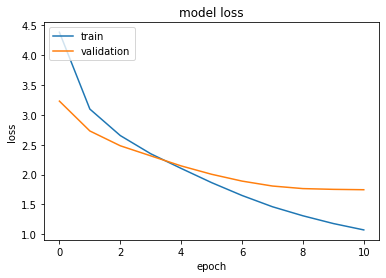

In [31]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history[0])
plt.plot(history[1])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

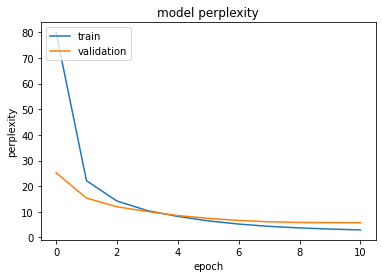

In [32]:
# perplexity is a measurement of how well a probability distribution or probability model predicts a sample. 
# It may be used to compare probability models.
# A low perplexity indicates the probability distribution is good at predicting the sample.
# summarize history for perplexity
plt.plot(history[2])
plt.plot(history[3])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Attention Visualization

In [33]:
#Visualizing the attention is the best part of working with transformers,
#it helps us in understanding what part of the input the model is paying more attention to

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Time taken to translate 0.09730958938598633 seconds
source = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
----------------------------------------------------------------------------------------------------
target = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']
----------------------------------------------------------------------------------------------------
translation = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'past', 'a', 'gate', '.']
----------------------------------------------------------------------------------------------------


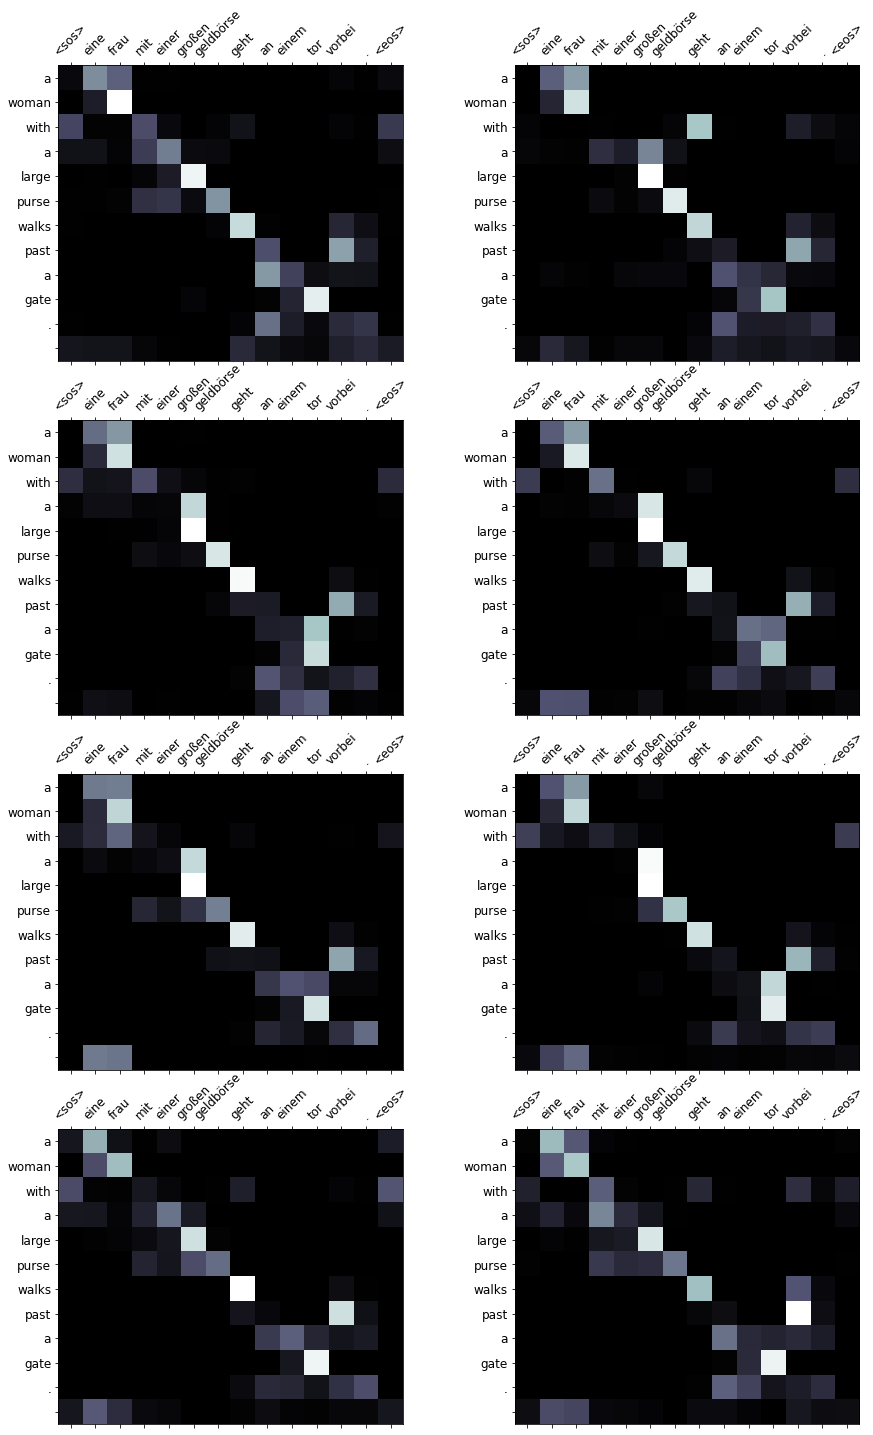

In [34]:
#see the attention from each head below. Each is certainly different, 
#but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to
#They all seem to follow the similar "downward staircase" pattern 
#And the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.
#Try 1: train_data
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']


translation, attention =  translate_sentence(src,
                                            source_process_pipeline,
                                            target_process_pipeline,
                                            spacy_german,
                                            transformer_model,device,
                                            max_length = 50,verbose = True)
print(f'source = {src}')
print('-'*100)
print(f'target = {trg}')
print('-'*100)
print(f'translation = {translation}')
print('-'*100)

display_attention(src, translation, attention,n_heads = NUM_DECODER_ATTN_HEADS)

Time taken to translate 0.08552002906799316 seconds
source = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']
----------------------------------------------------------------------------------------------------
target = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']
----------------------------------------------------------------------------------------------------
translation = ['a', 'woman', 'is', 'playing', 'a', 'song', 'on', 'their', 'violin', '.']
----------------------------------------------------------------------------------------------------


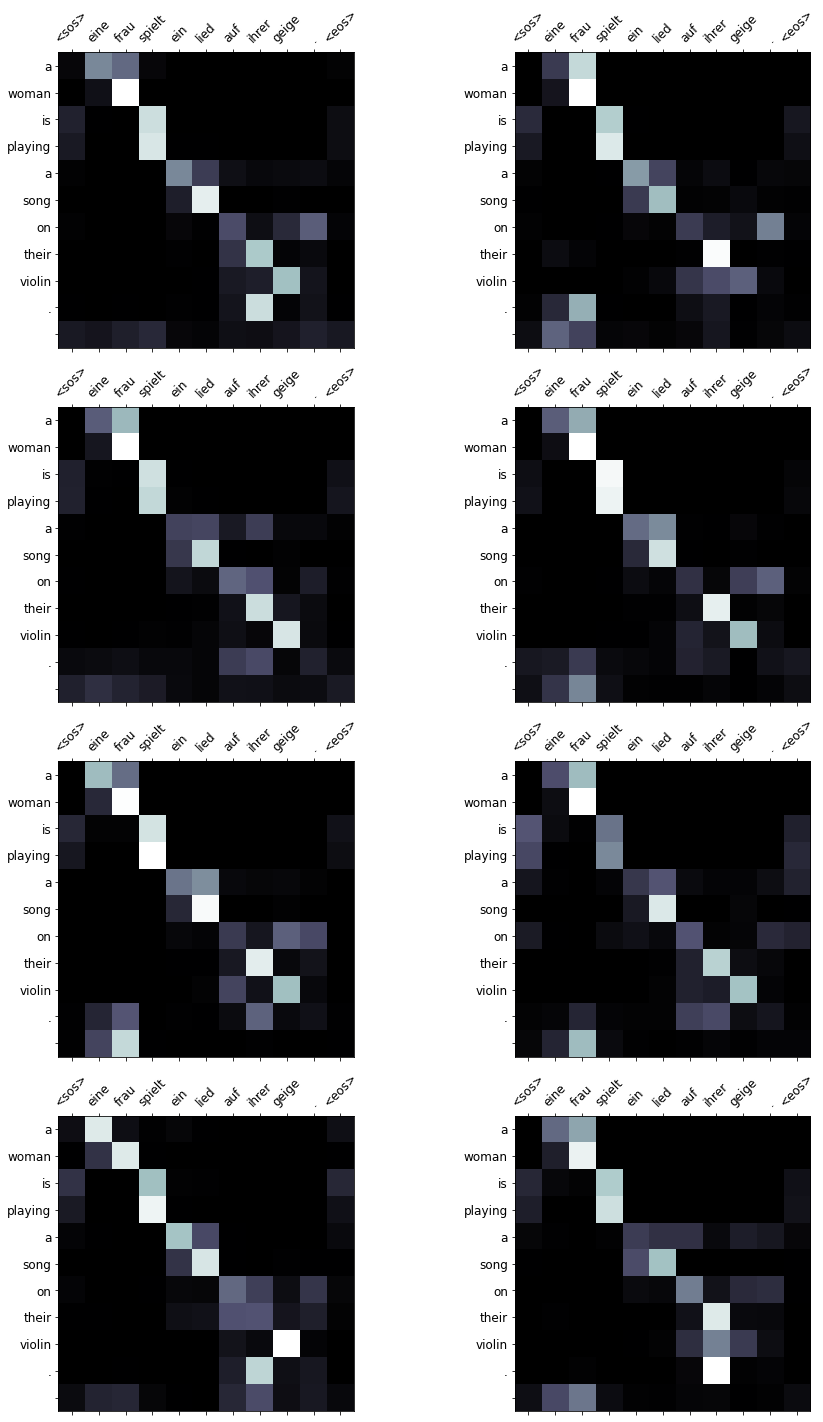

In [35]:
#Try 2 :validation_data
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']


translation, attention =  translate_sentence(src,
                                            source_process_pipeline,
                                            target_process_pipeline,
                                            spacy_german,
                                            transformer_model,device,
                                            max_length = 50,verbose = True)
print(f'source = {src}')
print('-'*100)
print(f'target = {trg}')
print('-'*100)
print(f'translation = {translation}')
print('-'*100)

display_attention(src, translation, attention,n_heads = NUM_DECODER_ATTN_HEADS)

Time taken to translate 0.06845927238464355 seconds
source = ['ein', 'typ', 'arbeitet', 'an', 'einem', 'gebäude', '.']
----------------------------------------------------------------------------------------------------
target = ['a', 'guy', 'works', 'on', 'a', 'building', '.']
----------------------------------------------------------------------------------------------------
translation = ['a', 'guy', 'working', 'on', 'a', 'building', '.']
----------------------------------------------------------------------------------------------------


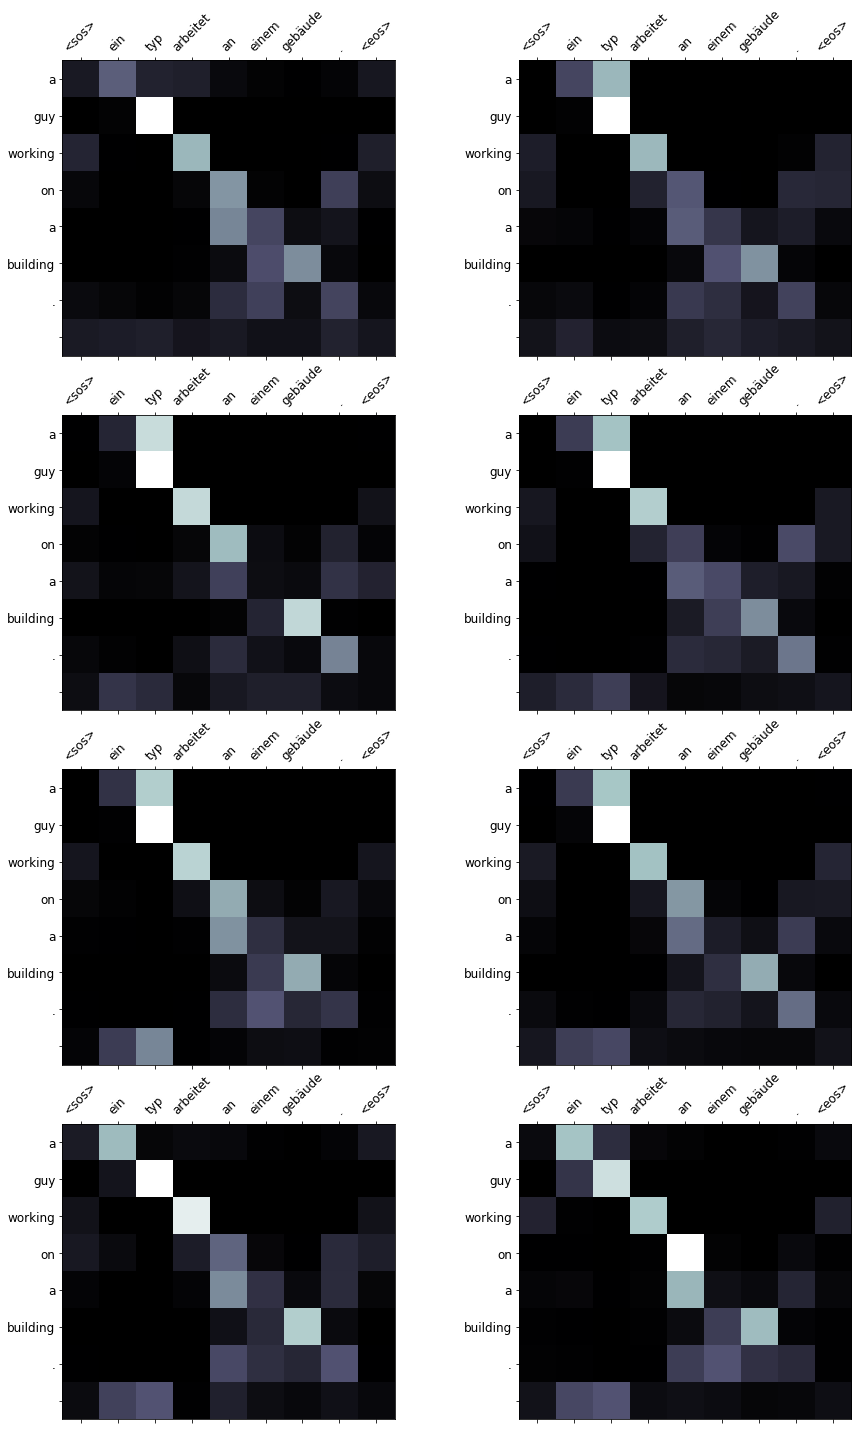

In [36]:
#Try 3:Test_data
example_idx = 8

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']


translation, attention =  translate_sentence(src,
                                            source_process_pipeline,
                                            target_process_pipeline,
                                            spacy_german,
                                            transformer_model,device,
                                            max_length = 50,verbose = True)
print(f'source = {src}')
print('-'*100)
print(f'target = {trg}')
print('-'*100)
print(f'translation = {translation}')
print('-'*100)

display_attention(src, translation, attention,n_heads = NUM_DECODER_ATTN_HEADS)

Time taken to translate 0.11145639419555664 seconds
source = ['eine', 'teenagerin', 'spielt', 'bei', 'einem', 'spiel', 'trompete', 'auf', 'dem', 'feld', '.']
----------------------------------------------------------------------------------------------------
target = ['a', 'teenager', 'plays', 'her', 'trumpet', 'on', 'the', 'field', 'at', 'a', 'game', '.']
----------------------------------------------------------------------------------------------------
translation = ['a', 'teenage', 'girl', 'is', 'playing', 'a', 'trumpet', 'in', 'a', 'field', '.']
----------------------------------------------------------------------------------------------------


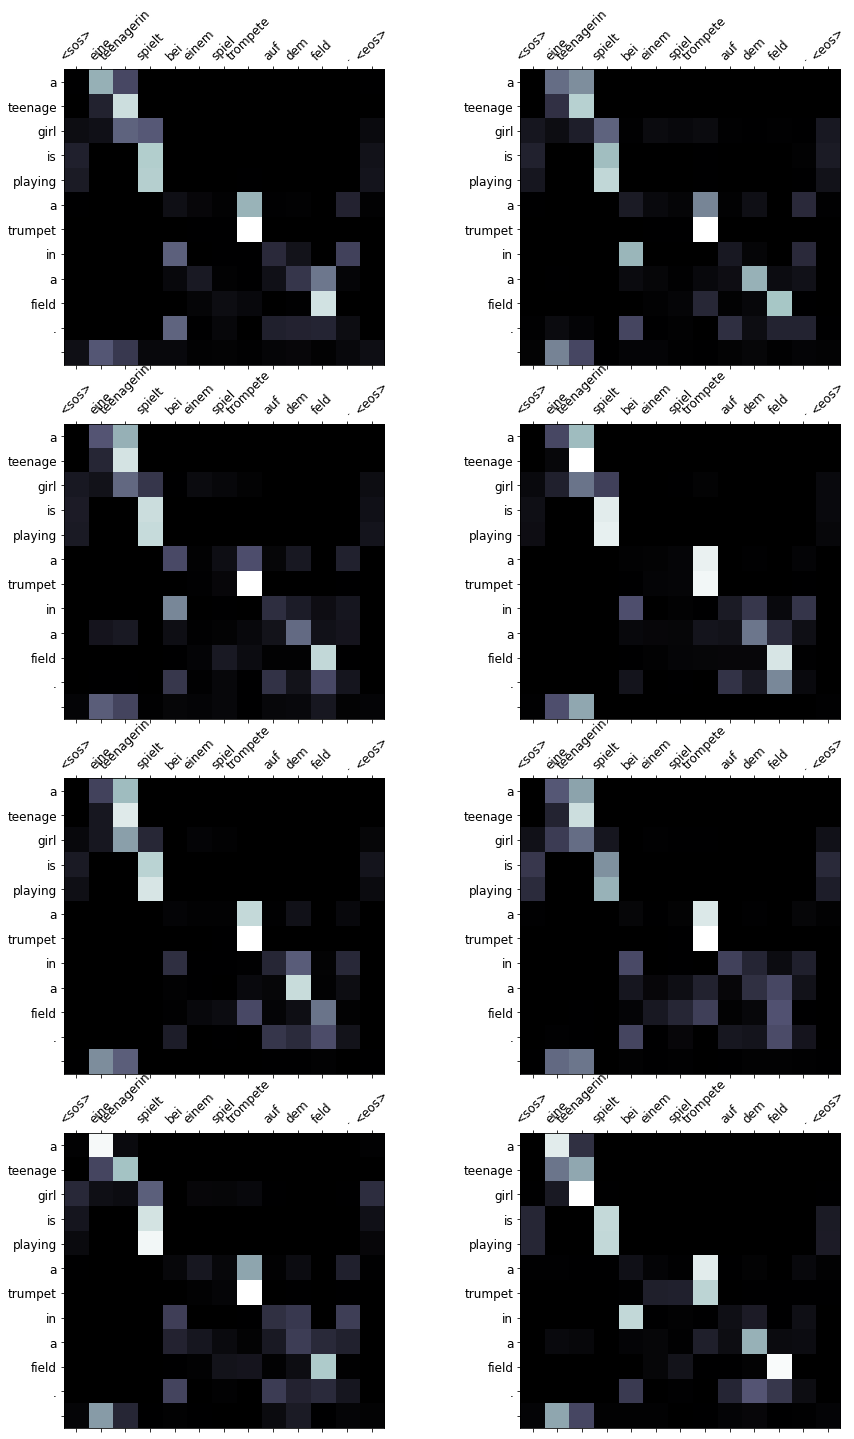

In [37]:
#Try 4:Test_data
example_idx = 21

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']


translation, attention =  translate_sentence(src,
                                            source_process_pipeline,
                                            target_process_pipeline,
                                            spacy_german,
                                            transformer_model,device,
                                            max_length = 50,verbose = True)
print(f'source = {src}')
print('-'*100)
print(f'target = {trg}')
print('-'*100)
print(f'translation = {translation}')
print('-'*100)

display_attention(src, translation, attention,n_heads = NUM_DECODER_ATTN_HEADS)

BLEU Score

In [38]:
#The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence. 
#A perfect match results in a score of 100.0, whereas a perfect mismatch results in a score of 0.0.

from torchtext.data.metrics import bleu_score

def calculate_bleu(data,source_field, target_field,source_tokenizer,
                       transformer_model,device, max_len = 50):
    
    transformer_model.eval()
    target_tokens = []
    predicted_tokens = []
    
    start = time()
    with torch.no_grad():
        
        for item in tqdm(data):
            
            source = vars(item)['src']
            target = vars(item)['trg']
                
            
            predicted_sentence,attention = translate_sentence(source,
                                                   source_field,target_field,
                                                   source_tokenizer,
                                                   transformer_model,device,
                                                   max_length = 50,verbose = False)
                
            predicted_tokens.append(predicted_sentence)
            target_tokens.append([target])
            

    return bleu_score(predicted_tokens, target_tokens)

In [39]:
bleu_score = calculate_bleu(test_data,source_process_pipeline,
                            target_process_pipeline,spacy_german,transformer_model,device, max_len = 50)


print(f'BLEU score on Test Data = {bleu_score*100}')
#We acheived a perplexity of ~35 , which quite good.


BLEU score on Test Data = 33.229780197143555
